# Modèle de Prédiction des Hospitalisations avec PyCaret

In [1]:
import numpy as np
from pycaret.regression import *
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from google.cloud import bigquery
import os

In [ ]:
'''

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/antob/Documents/Arctusol/projet_wagon/projet_data_JBN/projet-jbn-data-le-wagon-533639ce801d.json"
        # Initialisation du client BigQuery
client = bigquery.Client()

query = """
SELECT * FROM projet-jbn-data-le-wagon.dbt_medical_analysis_join_total_morbidite.class_join_total_morbidite_sexe_population

"""

df_hospi = client.query(query).to_dataframe()

'''


In [81]:
df_hospi = pd.read_csv("/content/df_hospi.csv")

In [3]:
df_hospi_dpt_ens = df_hospi[(df_hospi["niveau"] == "Départements") & (df_hospi["sexe"] == "Ensemble")]
df_hospi_dpt_HF = df_hospi[(df_hospi["niveau"] == "Départements") & (df_hospi["sexe"] != "Ensemble")]
df_hospi_reg_ens = df_hospi[(df_hospi["niveau"] == "Régions") & (df_hospi["sexe"] == "Ensemble")]
df_hospi_reg_HF = df_hospi[(df_hospi["niveau"] == "Régions") & (df_hospi["sexe"] != "Ensemble")]

In [4]:
df_hospi_dpt_ens_yr = df_hospi_dpt_ens[df_hospi_dpt_ens["annee"].isin([2018, 2019, 2020,2021, 2022])]
df_hospi_dpt_HF_yr =df_hospi_dpt_HF[df_hospi_dpt_HF["annee"].isin([2018, 2019,2020,2021, 2022])]


In [82]:
# On se base sur ce dataset
df_hospi_reg_ens_yr = df_hospi_reg_ens[df_hospi_reg_ens["annee"].isin([2018, 2019,2020,2021, 2022])]
df_hospi_reg_HF_yr =df_hospi_reg_HF[df_hospi_reg_HF["annee"].isin([2018, 2019, 2022])]

In [5]:
"""'hospi_prog_24h', 'hospi_autres_24h', 'hospi_total_24h',
    'hospi_1J', 'hospi_2J', 'hospi_3J', 'hospi_4J', 'hospi_5J',
    'hospi_6J', 'hospi_7J', 'hospi_8J', 'hospi_9J',
    'hospi_10J_19J', 'hospi_20J_29J', 'hospi_30J',
        'tranche_age_0_1', 'tranche_age_1_4', 'tranche_age_5_14',
    'tranche_age_15_24', 'tranche_age_25_34', 'tranche_age_35_44',
    'tranche_age_45_54', 'tranche_age_55_64', 'tranche_age_65_74',
    'tranche_age_75_84', 'tranche_age_85_et_plus'"""

"'hospi_prog_24h', 'hospi_autres_24h', 'hospi_total_24h',\n    'hospi_1J', 'hospi_2J', 'hospi_3J', 'hospi_4J', 'hospi_5J',\n    'hospi_6J', 'hospi_7J', 'hospi_8J', 'hospi_9J',\n    'hospi_10J_19J', 'hospi_20J_29J', 'hospi_30J',\n        'tranche_age_0_1', 'tranche_age_1_4', 'tranche_age_5_14',\n    'tranche_age_15_24', 'tranche_age_25_34', 'tranche_age_35_44',\n    'tranche_age_45_54', 'tranche_age_55_64', 'tranche_age_65_74',\n    'tranche_age_75_84', 'tranche_age_85_et_plus'"

In [6]:
# Préparation des données d'entraînement (2018-2019)
train_data_ens = df_hospi_reg_ens_yr[df_hospi_reg_ens_yr['annee'].isin([2018, 2019, 2020, 2021])]
test_data_ens = df_hospi_reg_ens_yr[df_hospi_reg_ens_yr['annee'] == 2022]

In [7]:
train_data_hf = df_hospi_reg_HF_yr[df_hospi_reg_HF_yr['annee'].isin([2018, 2019])]
test_data_hf = df_hospi_reg_HF_yr[df_hospi_reg_HF_yr['annee'] == 2022]

In [13]:
train_data_hf.head(1)

,nom_region,nom_pathologie,nbr_hospi
67695,Corse,Maladies intestinales infectieuses,222


In [8]:
# Sélection des variables pertinentes
features = [
    'nom_region', 'nom_pathologie'
]

In [9]:
# Préparation des données pour PyCaret
train_data_ens = train_data_ens[features + ['nbr_hospi']]
test_data_ens = test_data_ens[features + ['nbr_hospi']]
train_data_hf = train_data_hf[features + ['nbr_hospi']]
test_data_hf = test_data_hf[features + ['nbr_hospi']]

In [10]:
train_data_ens

,nom_region,nom_pathologie,nbr_hospi
10974,Corse,Maladies intestinales infectieuses,284
10978,Corse,Tuberculose,17
10981,Corse,Septicémies,175
10984,Corse,Mal.sexuellement transmissibles,85
10987,Corse,Hépatites virales,4
...,...,...,...
283174,Provence-Alpes-Côte d'Azur,Dialyse,1677
283177,Provence-Alpes-Côte d'Azur,Radiothérapie,2276
283179,Provence-Alpes-Côte d'Azur,Chimiothérapie pour tumeur,15439
283182,Provence-Alpes-Côte d'Azur,Surveil.post traitement med.ou chir.,67273


In [11]:
s = RegressionExperiment()

In [12]:
# Initialisation de l'environnement PyCaret
s.setup(
    data=train_data_ens,
    target='nbr_hospi',
    session_id=123,
    normalize=True,
    transformation=True,
    fold=10,  # 5-fold cross validation
)

,Description,Value
0,Session id,123
1,Target,nbr_hospi
2,Target type,Regression
3,Original data shape,"(11412, 3)"
4,Transformed data shape,"(11412, 20)"
5,Transformed train set shape,"(7988, 20)"
6,Transformed test set shape,"(3424, 20)"
7,Categorical features,2
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,537.1600,2568415.0827,1576.1248,0.9825,0.2634,0.1732,0.2400
dt,Decision Tree Regressor,541.0635,2624383.3662,1592.5309,0.9821,0.2648,0.1720,0.0550
rf,Random Forest Regressor,570.4297,2636340.3333,1599.7090,0.9819,0.2974,0.2190,0.2940
knn,K Neighbors Regressor,857.8942,5180655.8094,2267.9761,0.9633,0.4689,0.4334,0.0730
gbr,Gradient Boosting Regressor,1538.8888,8920770.9159,2978.9229,0.9377,1.4268,5.6390,0.1310
lightgbm,Light Gradient Boosting Machine,1258.6172,15894183.8156,3970.4533,0.8895,0.7815,1.1478,0.1280
ada,AdaBoost Regressor,3980.2502,50655191.1683,7110.3835,0.6439,2.0988,18.4857,0.0850
lar,Least Angle Regression,5133.2304,87999996.8022,9282.4872,0.4150,2.2755,35.6785,0.0490
br,Bayesian Ridge,5122.9347,88008914.4847,9282.6227,0.4150,2.2736,35.4961,0.0490
llar,Lasso Least Angle Regression,5132.2327,88001008.4841,9282.5129,0.4150,2.2755,35.6620,0.0500


In [ ]:
# Comparaison des modèles
best_model = compare_models(
    exclude=['ransac', 'huber', 'theilsen'],  # On exclut les modèles moins pertinents pour ce cas
    sort='R2',  # Trier par R2 score
    n_select=1  # Sélectionner le meilleur modèle
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,210.2197,1674098.7103,1127.0726,0.9912,0.1773,0.0527,0.3640
gbr,Gradient Boosting Regressor,427.6667,2396550.7742,1420.5155,0.9862,0.5982,0.5865,0.2560
rf,Random Forest Regressor,349.7305,3296375.6789,1671.1827,0.9817,0.1999,0.0719,0.7120
dt,Decision Tree Regressor,610.6284,5607087.2998,2317.2817,0.9645,0.3366,0.1542,0.0560
lightgbm,Light Gradient Boosting Machine,501.0182,6291665.5423,2360.0732,0.9639,0.3945,0.1959,0.1180
knn,K Neighbors Regressor,800.0081,10478549.6767,3090.5007,0.9385,0.2794,0.1512,0.0600
ada,AdaBoost Regressor,5000.6533,30007587.1691,5451.3783,0.8026,2.5210,36.7323,0.1200
br,Bayesian Ridge,5146.4878,87145760.0359,9205.0350,0.4519,2.2289,40.2128,0.0520
ridge,Ridge Regression,5159.7623,87114678.7928,9204.7875,0.4518,2.2378,41.0608,0.0460
llar,Lasso Least Angle Regression,5159.5210,87113806.6104,9204.7043,0.4518,2.2394,41.0670,0.0560


In [ ]:
s.get_config("pipeline")

Pipeline(memory=FastMemory(location=C:\Users\antob\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=[], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['nom_region', 'nom_pathologie'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['...
                                    transformer=OneHotEncoder(cols=['nom_region'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['nom_pathologie'],
                                    transformer=TargetEncoder(cols=['nom_pathologie'],
                                                              handle_missing='return_nan'))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize',
                 TransformerWrapper(transformer=StandardScaler()))])

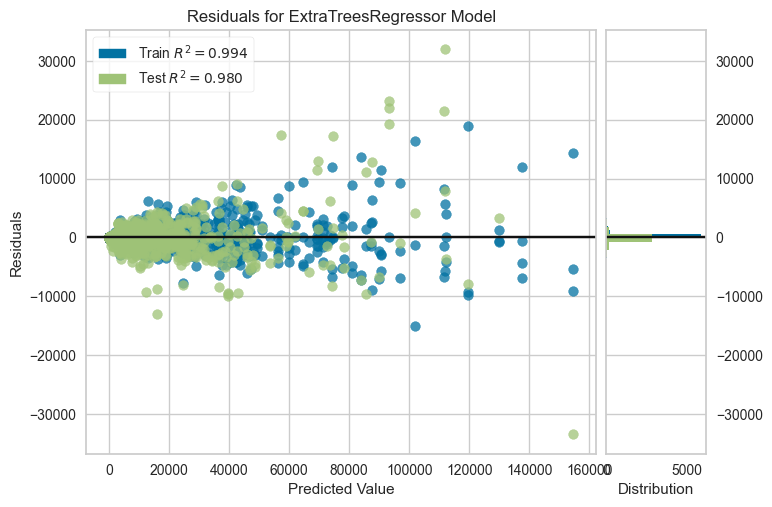

In [ ]:
s.plot_model(best)

In [ ]:
# Ajout après la comparaison des modèles
from sklearn.model_selection import cross_val_score

# Validation croisée sur le meilleur modèle
cv_scores = cross_val_score(best_model, train_data.drop('nbr_hospi', axis=1),
                          train_data['nbr_hospi'],
                          cv=5,
                          scoring='r2')

print("Scores de validation croisée (R²):")
print(f"Moyenne: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Anémies'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Maladies intestinales infectieuses'


In [ ]:
# Tuning du meilleur modèle
tuned_model = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,731.6418,3547888.6497,1883.5840,0.9689,0.4504,0.4162
1,862.1841,10623691.8239,3259.4005,0.9404,0.5248,0.5540
2,725.7575,3818782.2306,1954.1705,0.9752,0.5283,0.4961
3,1043.8685,22943884.0537,4789.9775,0.8993,0.5648,0.4763
4,649.8662,2279363.4565,1509.7561,0.9791,0.5447,0.5012
Mean,802.6636,8642722.0429,2679.3777,0.9526,0.5226,0.4888
Std,138.5844,7722273.3861,1209.8170,0.0299,0.0388,0.0445


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# Analyse du MAE en contexte
print("Statistiques du nombre d'hospitalisations:")
print(train_data['nbr_hospi'].describe())

# Calcul du MAE relatif
mae_relatif = 211 / train_data['nbr_hospi'].mean() * 100
print(f"\nMAE en pourcentage de la moyenne: {mae_relatif:.2f}%")

# Distribution des erreurs
plt.figure(figsize=(10, 6))
erreurs = abs(predictions['nbr_hospi'] - predictions['prediction_label'])
sns.histplot(data=erreurs[erreurs < erreurs.quantile(0.95)], bins=50)
plt.axvline(x=211, color='r', linestyle='--', label='MAE')
plt.title('Distribution des erreurs absolues')
plt.xlabel('Erreur absolue (nombre d\'hospitalisations)')
plt.legend()
plt.show()

Statistiques du nombre d'hospitalisations:


NameError: name 'train_data' is not defined

In [ ]:
test_data_sans_nom = test_data_ens.drop(["nbr_hospi"], axis=1)

In [ ]:
test_data_ens

,niveau,cle_unique,sexe,year,annee,pathologie,code_pathologie,nom_pathologie,region,code_region,...,tx_standard_tt_age_pour_mille,indice_comparatif_tt_age_percent,evolution_tx_brut_tt_age_pour_mille,evolution_percent_tx_brut_tt_age_pour_mille,evolution_tx_standard_tt_age_pour_mille,evolution_percent_tx_standard_tt_age_pour_mille,evolution_indice_comparatif_tt_age_percent,evolution_percent_indice_comparatif_tt_age_percent,classification,population
124180,Régions,94 - Corse_01001_2022,Ensemble,2022-12-31,2022,01001-Maladies intestinales infectieuses,01001,Maladies intestinales infectieuses,94 - Corse,94,...,1.34,78.80,0.38,0.46,0.43,0.47,18.26,0.30,M,347000
124183,Régions,94 - Corse_01002_2022,Ensemble,2022-12-31,2022,01002-Tuberculose,01002,Tuberculose,94 - Corse,94,...,0.05,73.66,0.00,0.00,0.00,0.07,7.06,0.11,M,347000
124188,Régions,94 - Corse_01003_2022,Ensemble,2022-12-31,2022,01003-Septicémies,01003,Septicémies,94 - Corse,94,...,0.36,141.92,-0.03,-0.05,-0.01,-0.03,8.71,0.07,M,347000
124191,Régions,94 - Corse_01004_2022,Ensemble,2022-12-31,2022,01004-Mal.sexuellement transmissibles,01004,Mal.sexuellement transmissibles,94 - Corse,94,...,0.24,137.51,-0.03,-0.14,-0.03,-0.11,-9.69,-0.06,M,347000
124192,Régions,94 - Corse_01005_2022,Ensemble,2022-12-31,2022,01005-Hépatites virales,01005,Hépatites virales,94 - Corse,94,...,0.06,128.49,0.05,7.00,0.02,0.62,49.75,0.67,M,347000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169979,Régions,93 - Provence-Alpes-Côte d'Azur_21155_2022,Ensemble,2022-12-31,2022,21155-Radiothérapie,21155,Radiothérapie,93 - Provence-Alpes-Côte d'Azur,93,...,0.40,140.75,0.03,0.06,0.02,0.05,1.70,0.01,C,5099000
169981,Régions,93 - Provence-Alpes-Côte d'Azur_21156_2022,Ensemble,2022-12-31,2022,21156-Chimiothérapie pour tumeur,21156,Chimiothérapie pour tumeur,93 - Provence-Alpes-Côte d'Azur,93,...,2.19,123.51,-0.22,-0.08,-0.18,-0.07,-0.79,-0.01,C,5099000
169985,Régions,93 - Provence-Alpes-Côte d'Azur_21157_2022,Ensemble,2022-12-31,2022,21157-Surveil.post traitement med.ou chir.,21157,Surveil.post traitement med.ou chir.,93 - Provence-Alpes-Côte d'Azur,93,...,13.20,106.95,0.74,0.05,0.69,0.05,1.15,0.01,ESND,5099000
169987,Régions,93 - Provence-Alpes-Côte d'Azur_21158_2022,Ensemble,2022-12-31,2022,21158-Recours raison économique ou sociale,21158,Recours raison économique ou sociale,93 - Provence-Alpes-Côte d'Azur,93,...,0.24,79.40,-0.05,-0.13,-0.03,-0.11,-6.75,-0.08,ESND,5099000


In [ ]:
# Évaluation sur les données de test (2022)
predictions = s.predict_model(best, data=test_data_sans_nom)
print("Performance sur les données de test (2022):")
print(predictions["prediction_label"].head())

Performance sur les données de test (2022):
124180    380.0
124183     18.0
124188    196.0
124191     69.0
124192     13.0
Name: prediction_label, dtype: float64


In [ ]:
test_data_ens["nbr_hospi"].head()

124180    417
124183     18
124188    168
124191     74
124192     19
Name: nbr_hospi, dtype: Int64

Métriques sur les données de test (2022):
MAE: 239.12
RMSE: 1381.96
R²: 0.9888


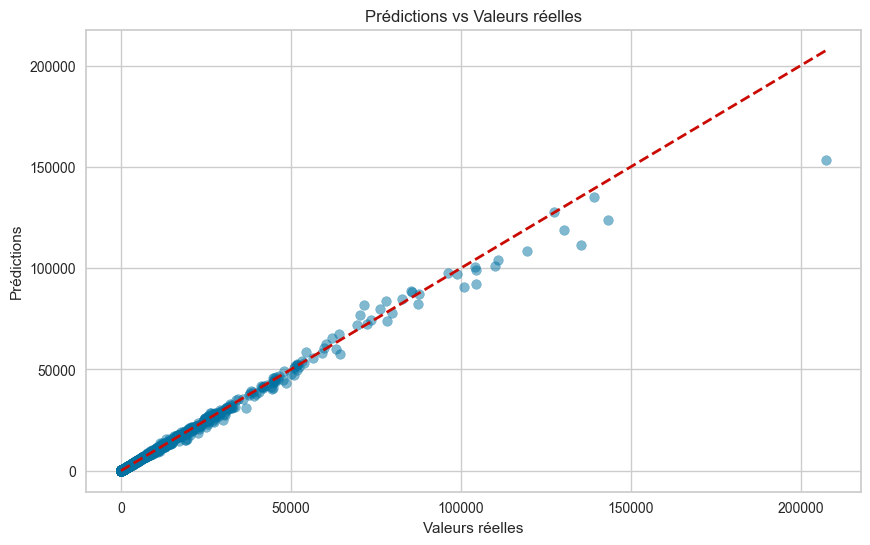


Statistiques des erreurs relatives (%):
count      2862.0
mean          inf
std          <NA>
min           0.0
25%      1.505772
50%      3.386791
75%      6.304061
max           inf
Name: erreur_relative, dtype: Float64


In [ ]:
bb# Calcul des métriques d'erreur pour les prédictions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire les vraies valeurs et les prédictions
y_true = predictions['nbr_hospi']
y_pred = predictions['prediction_label']

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Métriques sur les données de test (2022):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.show()

# Calcul et affichage des erreurs relatives
predictions['erreur_relative'] = abs(predictions['nbr_hospi'] - predictions['prediction_label']) / predictions['nbr_hospi'] * 100
print("\nStatistiques des erreurs relatives (%):")
print(predictions['erreur_relative'].describe())

In [14]:
###################### Test will ######################

In [83]:
df_hospi_reg_ens_yr.annee.unique()

array([2021, 2019, 2022, 2020, 2018])

In [84]:
df_hospi_reg_ens_yr.head(1)

,Unnamed: 0,niveau,cle_unique,sexe,year,annee,pathologie,code_pathologie,nom_pathologie,region,...,tx_standard_tt_age_pour_mille,indice_comparatif_tt_age_percent,evolution_tx_brut_tt_age_pour_mille,evolution_percent_tx_brut_tt_age_pour_mille,evolution_tx_standard_tt_age_pour_mille,evolution_percent_tx_standard_tt_age_pour_mille,evolution_indice_comparatif_tt_age_percent,evolution_percent_indice_comparatif_tt_age_percent,classification,population
10974,10974,Régions,94 - Corse_01001_2021,Ensemble,2021-12-31,2021,01001-Maladies intestinales infectieuses,1001,Maladies intestinales infectieuses,94 - Corse,...,0.91,60.41,0.01,0.02,0.08,0.1,-15.42,-0.2,M,344000


In [85]:
df_hospi_reg_ens_yr.drop("Unnamed: 0", axis=1, inplace=True)

In [86]:
df_hospi_reg_ens_yr.columns

Index(['niveau', 'cle_unique', 'sexe', 'year', 'annee', 'pathologie',
       'code_pathologie', 'nom_pathologie', 'region', 'code_region',
       'nom_region', 'nbr_hospi', 'evolution_nbr_hospi',
       'evolution_percent_nbr_hospi', 'hospi_prog_24h', 'hospi_autres_24h',
       'hospi_total_24h', 'hospi_1J', 'hospi_2J', 'hospi_3J', 'hospi_4J',
       'hospi_5J', 'hospi_6J', 'hospi_7J', 'hospi_8J', 'hospi_9J',
       'hospi_10J_19J', 'hospi_20J_29J', 'hospi_30J', 'hospi_total_jj',
       'total_hospi', 'AVG_duree_hospi', 'evolution_hospi_total_24h',
       'evolution_percent_hospi_total_24h', 'evolution_hospi_total_jj',
       'evolution_percent_hospi_total_jj', 'evolution_total_hospi',
       'evolution_percent_total_hospi', 'evolution_AVG_duree_hospi',
       'evolution_percent_AVG_duree_hospi', 'tranche_age_0_1',
       'tranche_age_1_4', 'tranche_age_5_14', 'tranche_age_15_24',
       'tranche_age_25_34', 'tranche_age_35_44', 'tranche_age_45_54',
       'tranche_age_55_64', 'tranche

In [87]:
data = df_hospi_reg_ens_yr[["annee","nom_region","nom_pathologie","nbr_hospi"]]

In [88]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error


# Feature engineering (e.g., lag features)
data['lag_1'] = data.groupby(['nom_region', 'nom_pathologie'])['nbr_hospi'].shift(1)
data = data.dropna()


In [89]:
data_encoded = pd.get_dummies(data, columns=['nom_region', 'nom_pathologie'], drop_first=False)


In [90]:
data_encoded.annee.unique()

array([2019, 2022, 2020, 2018])

In [92]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Assuming 'data' is your DataFrame with historical data

# Define the feature and target columns
feature_columns = [col for col in data_encoded.columns if col not in ['nbr_hospi']]
target_column = 'nbr_hospi'

# Split historical data into train and validation sets
train = data_encoded[data_encoded['annee'] <= 2021]
valid = data_encoded[data_encoded['annee'] == 2022]

X_train = train[feature_columns]
y_train = train[target_column]
X_valid = valid[feature_columns]
y_valid = valid[target_column]

# Train the initial model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Validate on 2020
y_pred_valid = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred_valid)
print(f"Validation MAE for 2022: {mae}")

# Generate future data and iteratively predict
future_years = [2023, 2024, 2025, 2026]
future_data = []

# Start from the last available year
last_year_data = data_encoded[data_encoded['annee'] == 2022].copy()

for year in future_years:
    # Create future data based on the last year's data
    temp_data = last_year_data.copy()
    temp_data['annee'] = year

    # Update lag_1 with the last year's predictions
    if len(future_data) > 0:
        temp_data['lag_1'] = future_data[-1]['nbr_hospi'].values

    # Predict for the current year
    X_future = temp_data[feature_columns]
    preds = model.predict(X_future)

    # Update predictions in the temp_data
    temp_data['nbr_hospi'] = preds

    # Append the temp_data to the future_data list
    future_data.append(temp_data)

    # Refit the model with the newly predicted data
    X_train = pd.concat([X_train, X_future], ignore_index=True)
    y_train = pd.concat([y_train, pd.Series(preds)], ignore_index=True)
    model.fit(X_train, y_train)

# Combine all future data into a single DataFrame
future_data = pd.concat(future_data, ignore_index=True)

# Display the predictions
print(future_data[['annee', 'nbr_hospi']])

Validation MAE for 2022: 836.0356269421112
       annee     nbr_hospi
0       2023    355.102845
1       2023     37.506540
2       2023     83.272036
3       2023     37.506540
4       2023     37.506540
...      ...           ...
11443   2026   2013.139527
11444   2026  10624.308232
11445   2026  53629.107757
11446   2026   2013.139527
11447   2026  64073.216541

[11448 rows x 2 columns]


In [77]:
data_encoded.annee.unique()

array([2022, 2020, 2018])